In [1]:
import glob
import cv2
from skimage import img_as_float, img_as_ubyte
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

s_test_data_dir = './training_data/'

def resize11(image):
    return cv2.resize(image,(69, 69), interpolation = cv2.INTER_LINEAR)
def crop(image,x,y):
    return image[y:y+64,x:x+64]
def rot(image, angle):
    rows,cols = 64,64
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle, 1.1)
    return cv2.warpAffine(image,M,(cols,rows))
def tiltUp(image):
    rows,cols,ch = image.shape
    pts1 = np.float32([[5,5],[64-5,5],[0,64],[64,64]])
    pts2 = np.float32([[0,0],[64,0],[0,64],[64,64]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(image,M,(64,64))
    return dst
def tiltDown(image):
    rows,cols,ch = image.shape
    pts1 = np.float32([[0,0],[64,0],[5,64-5],[64-5,64-5]])
    pts2 = np.float32([[0,0],[64,0],[0,64],[64,64]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(image,M,(64,64))
    return dst
def twistLeft(image):
    rows,cols,ch = image.shape
    pts1 = np.float32([[0,0],[64-5,5],[0,64],[64-5,64-5]])
    pts2 = np.float32([[0,0],[64,0],[0,64],[64,64]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(image,M,(64,64))
    return dst

def twistRight(image):
    rows,cols,ch = image.shape
    pts1 = np.float32([[5,5],[64,0],[5,64-5],[64,64]])
    pts2 = np.float32([[0,0],[64,0],[0,64],[64,64]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(image,M,(64,64))
    return dst

def shift(image):
    return crop(resize11(image),random.randint(0,5),random.randint(0,5))
def rotCCW(image):
    return rot(image,-random.randint(3,10))
def rotCW(image):
    return rot(image, random.randint(3,10))
def gaussian(image):
    return cv2.blur(image,(3,3))
def original(img):
    return img
def flip(img):
    return cv2.flip(img,1)


s_augment_list   = [  original,
                      shift,
                      shift,
                      rotCCW,
                      rotCW,
                      gaussian,
                      tiltUp,
                      tiltDown,
                      twistLeft,
                      twistRight,
                      lambda x: flip(original(x)),
                      lambda x: flip(shift(x)),
                      lambda x: flip(shift(x)),
                      lambda x: flip(rotCCW(x)),
                      lambda x: flip(rotCW(x)),
                      lambda x: flip(gaussian(x)),
                      lambda x: flip(tiltUp(x)),
                      lambda x: flip(tiltDown(x)),
                      lambda x: flip(twistLeft(x)),
                      lambda x: flip(twistRight(x))
                   ]

def get_data_list(dirs):
    images_cars = glob.glob(dirs+'vehicles/**/*.png',recursive=True)
    images_non_cars = glob.glob(dirs+'non-vehicles/**/*.png',recursive=True)
    assert  len(images_cars) !=0, 'No car images'
    assert  len(images_non_cars)!=0, 'No non car images'
    samples_list = []
    for file in images_cars:
            samples_list.append((file, [1, 0]))
    for file in images_non_cars:
            samples_list.append((file, [0, 1]))
    return samples_list

def augment_data_list(data_list, augment_list):
    samples_list =[]
    for file, iscar in data_list:
        for aug in augment_list:
            samples_list.append((file, iscar, aug))
    return samples_list

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
def generator(samples, batch_size=32):
    """

    :param samples: list of rows from csv file with corrected address and augment index
    :param batch_size: number of images to return each iteration
    :return: tuple of 4D image array (batch, height, width, channels) and steering angels (batch, 1)
    """
    num_samples = len(samples)

    while 1:  # Loop forever so the generator never terminates
        samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            images = []
            i_class = []
            for file_name, is_car, aug in batch_samples:
                image_orig = img_as_float(convert_color(cv2.cvtColor(cv2.imread(file_name),cv2.COLOR_BGR2RGB)))
                images.append(aug(image_orig))
                i_class.append(is_car)
            x_data = np.array(images)
            y_data = np.array(i_class)
            yield shuffle(x_data, y_data)


Using TensorFlow backend.


In [2]:

print(len(augment_data_list(get_data_list(s_test_data_dir),s_augment_list)))
print(augment_data_list(get_data_list(s_test_data_dir),s_augment_list)[0])
print(generator(augment_data_list(get_data_list(s_test_data_dir),s_augment_list), batch_size=32))

355200
('./training_data/vehicles\\GTI_Far\\image0000.png', [1, 0], <function original at 0x000000000BB20C80>)
<generator object generator at 0x00000000041C1620>


In [2]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D
from keras.layers import Deconvolution2D
from keras.layers import Activation, Dropout
from keras.layers import Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.initializers import Ones, Zeros
def model_conv_main(input_shape):
    """
    :return: keras model of Nvidia network with a single dropout layer
    """
    model = Sequential()
    model.add(Lambda(lambda x: x - 0.5, input_shape =(input_shape[0], input_shape[1], 3)))
    model.add(Convolution2D(12, (5, 5), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.3))
    model.add(Convolution2D(24, (5, 5), strides=(2, 2), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(36, (5, 5), strides=(2, 2), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(46, (3, 3), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #classification head
    model.add(Dropout(0.6))
    model.add(Convolution2D(20,(3, 3), kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Convolution2D(10,(1,1), kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Convolution2D(2,(1,1), activation='softmax'))

    return model

def model_conv_train():
    model = model_conv_main((64,64))
    # flat for teaching 
    model.add(Flatten()) 
    return model


In [3]:
def main():
    """
    The training pipe line

    :return: train history data, model with minimal validation loss, and final model
    """
    samples = get_data_list(s_test_data_dir)
    model = model_conv_train()
  
    train_samples, validation_samples = train_test_split(samples, test_size=0.2)
    # compile and train the model using the generator function
    train_samples = augment_data_list(train_samples,s_augment_list)
    validation_samples = augment_data_list(validation_samples, [original])
    
    train_generator = generator(train_samples, batch_size=32)
    validation_generator = generator(validation_samples, batch_size=32)

    model.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'], 
                  optimizer='adam')
    # save best model based on the minimal validation loss
    file_name = "nn_classifier"
    s_epoch = 50
    saver = ModelCheckpoint(
        filepath='result_conv/' + file_name + '_best{val_loss:.2f}.h5',
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        period=1)
    # if validation loss does not improve of next 5 epoch stop
    killer = EarlyStopping(
        monitor='val_loss',
        min_delta=0.00001,
        patience=10,
        verbose=0,
        mode='auto')
    # train and store history
    train_history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_samples) //32,
       # samples_per_epoch=len(train_samples),
        validation_data=validation_generator,
        validation_steps=len(validation_samples) //32,
        epochs=s_epoch,
        callbacks=[saver, killer])
    # store the model
    model.save('result_conv/' + file_name + '.h5')
    # store history
    with open('result_conv/p_' + file_name + '.p', 'wb') as f:
        pickle.dump(train_history.history, f)
#main()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


[]

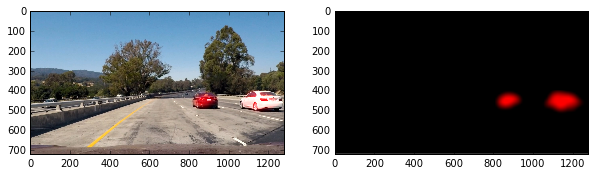

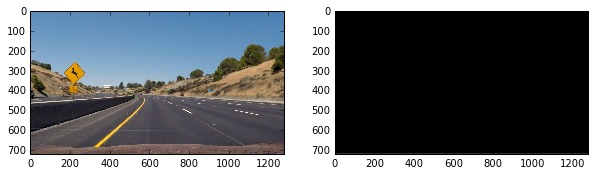

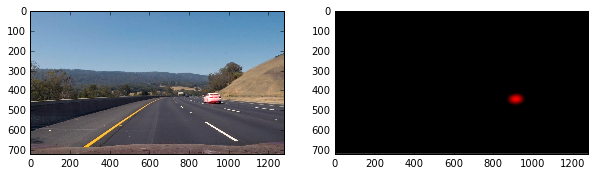

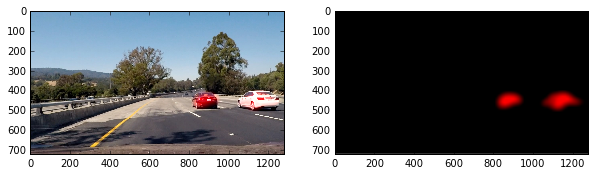

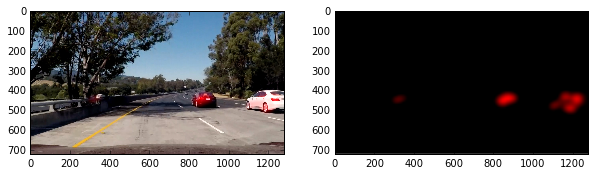

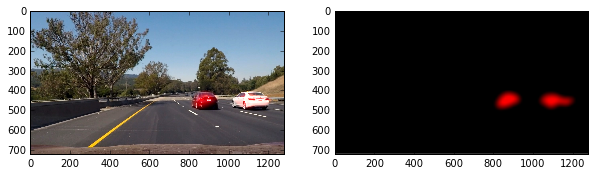

In [17]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline 
def showUnique(images, labels):
    unique_lables = np.unique(labels)
    image_list =[]
    for label in unique_lables:
        for i in range(6):
            image_list.append((images[np.where(labels==label)[0][i]],label))
    fig = plt.figure(figsize=(10, 15))
    for image_index in range(len(image_list)):
        ax = fig.add_subplot(8,6,image_index+1)
        image_name = image_index
        image, label = image_list[image_index]
        plt.imshow(image)
        ax.text(0.0, 0.0, '{:1.0f}'.format(label), fontsize=11)
  
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
    plt.show()

def test():
    gen = generator(augment_data_list(get_data_list(s_test_data_dir),[original]), batch_size=32)
    x_data, y_data = next(gen)
    showUnique(*shuffle(x_data, y_data))
#test()

class Image2CarHeat(object):
    def __init__(self, input_shape, weights_address):
        self.model = model_conv_main(input_shape)
        self.model.add(Deconvolution2D(1,(5,5)))
        self.model.add(Deconvolution2D(1,(5,5)))
        temp = load_model(weights_address)
        weights = temp.get_weights()
        weights_man = [np.zeros((5,5,1,2),np.float32),
                       np.zeros(1,np.float32) - 0.5,
                       np.ones((5,5,1,1),np.float32),
                       np.zeros(1,np.float32)]
        weights_man[0][:,:,0,0]=cv2.getGaussianKernel(5,-1) 
        weights=weights + weights_man
        self.model.set_weights(weights)
    def process(self,img_test):
        img_test = np.asarray(img_test)
        result = self.model.predict(img_test[None, :, :, :], batch_size=1)
        # simplificaiton  this can be treated as convolutions of the network, but it is quicker to implement via cv then keras
        result = np.squeeze(result[0,:,:,0])      
        #result = cv2.inRange(result, 0.9 ,1.1)
        #result = cv2.dilate(result, np.ones((3,3),result.dtype),5) 
        #result = cv2.erode(result, np.ones((3,3),result.dtype),6)
        result = np.clip(result, 0, 100)
        if np.max(result) > 1.0:
            result = result/np.max(result)
        result = cv2.resize(result,(img_test.shape[1],img_test.shape[0]), interpolation = cv2.INTER_LINEAR)
        return result
def test_1():
    gen = generator(augment_data_list(get_data_list(s_test_data_dir),[original]), batch_size=32)
    x_data, y_data = next(gen)
    img = x_data[1,:,:,:].astype(np.float32)
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB))
    model=model_conv_heat((64,64),'./result_conv/nn_classifier_best0.00.h5')
    result=np.reshape(model.predict(x_data[0:1,:,:,:], batch_size=1),(64,64))
    print(result.shape)
    print(result)
    ax2.imshow(result, cmap='gray')
#test_1()
def test_2():
    %time model=model_conv_heat((720, 1280),'./result_conv/nn_classifier_best0.00.h5')
    
    img = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'),cv2.COLOR_BGR2RGB)
    img_test = img_as_float(convert_color(img))
    img_test = np.asarray(img_test)
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(img)
    print(img.shape[0:2])
    
    result= model.predict(img_test[None, :, :, :], batch_size=1)
    print(result.shape)
    result = np.squeeze(result[0,:,:,0])
    result = cv2.resize(result,(img.shape[1],img.shape[0]), interpolation = cv2.INTER_LINEAR)
    #print(result)
    ax2.imshow(result, cmap='gray',interpolation='none')
#test_2()
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)
def output_images():
    # Test undistortion on an image
    model=Image2CarHeat((720, 1280),'./result_conv/nn_classifier_best0.00.h5')
    dir_name = "./test_images"
    file_list = glob.glob(dir_name + "/*.jpg")
    image_list =[]
    for file_name in tqdm(file_list):
        img = cv2.cvtColor(cv2.imread(file_name),cv2.COLOR_BGR2RGB)
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
        img_test = img_as_float(convert_color(img))
        result = model.process(img_test)
        result[0:400,:] = 0.0
        v_result = img_as_ubyte(np.dstack((result,np.zeros_like(result),np.zeros_like(result)))/np.max(result))
        ax1.imshow(weighted_img(img,v_result))
        ax2.imshow(v_result,interpolation='none')
        #fig.savefig("./output_images/"+ file_name.split('/')[-1], bbox_inches='tight')
    return image_list
    
output_images()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.43s/it]


[]

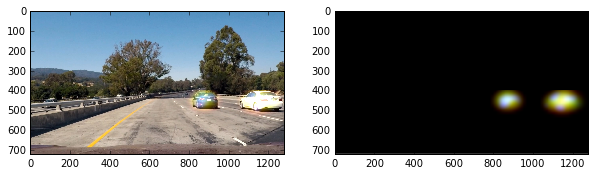

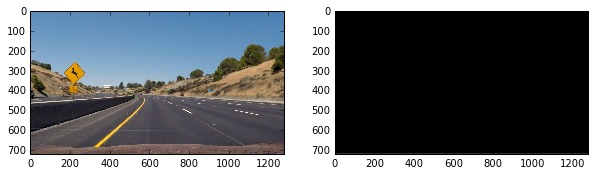

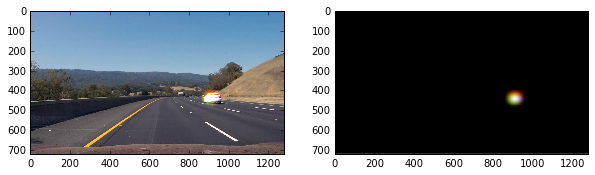

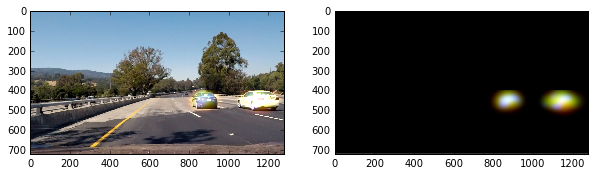

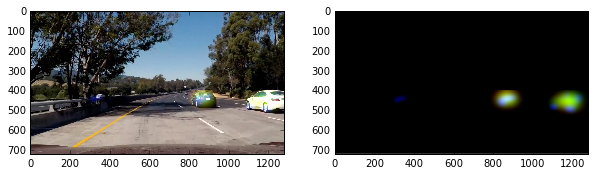

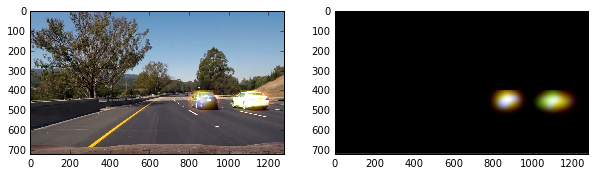

In [18]:
class FindCars(object):
    def __init__(self, imshape, ystart, ystop, scale, weights_address):
        self.scale = scale
        self.ystart = ystart
        self.ystop = ystop
        self.heat_gen = Image2CarHeat((np.int( imshape[0]/scale), np.int(imshape[1]/scale)), weights_address)
    def process(self, img):
        img = img_as_float(convert_color(img))

        img_tosearch = img[:,:,:]
        ctrans_tosearch = img_tosearch
        imshape = ctrans_tosearch.shape
        if self.scale != 1:
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/self.scale), np.int(imshape[0]/self.scale)))
        heat = self.heat_gen.process(ctrans_tosearch)
        heat = cv2.resize(heat, (np.int(imshape[1]), np.int(imshape[0])))
        heat[:self.ystart,:] = 0.0
        heat[self.ystop:,:] = 0.0
        return heat
def test():
     # Test undistortion on an image
    fc1=FindCars((720, 1280),400,656, 2.0,'./result_conv/nn_classifier_best0.00.h5')
    fc2=FindCars((720, 1280),400,656, 1.5,'./result_conv/nn_classifier_best0.00.h5')
    fc3=FindCars((720, 1280),400,656, 0.75,'./result_conv/nn_classifier_best0.00.h5')
    dir_name = "./test_images"
    file_list = glob.glob(dir_name + "/*.jpg")
    image_list =[]
    for file_name in tqdm(file_list):
        img = cv2.cvtColor(cv2.imread(file_name),cv2.COLOR_BGR2RGB)
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
        v_result = np.dstack((fc1.process(img),fc2.process(img),fc3.process(img)))
        v_result =v_result/np.max(v_result)
        v_result = img_as_ubyte(v_result)
        ax1.imshow(weighted_img(img,v_result))
        ax2.imshow(v_result,interpolation='none')
        #fig.savefig("./output_images/"+ file_name.split('/')[-1], bbox_inches='tight')
    return image_list
test()

In [14]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [15]:
from skimage import img_as_ubyte

class Pipeline(object):
    def __init__(self,keep_heat = False):
        self.heat = None
        self.keep_heat = keep_heat
        self.fc1=FindCars((720, 1280),400,656, 2.0,'./result_conv/nn_classifier_best0.00.h5')
        self.fc2=FindCars((720, 1280),400,656, 1.5,'./result_conv/nn_classifier_best0.00.h5')
        self.fc3=FindCars((720, 1280),400,656, 0.75,'./result_conv/nn_classifier_best0.00.h5')
    def process(self, img):
      
        heat = np.dstack((self.fc1.process(img) ,self.fc2.process(img), self.fc3.process(img)))
        heat_img = img_as_ubyte(heat)
        heat_val = heat[:,:,0] + heat[:,:,1] + heat[:,:,2]
        

        if self.heat is None:
            self.heat = np.zeros_like(heat_val)
            
        if self.keep_heat:
            self.heat = self.heat + heat_val - 0.5
        else:
            self.heat = heat_val - 0.5
        self.heat = apply_threshold(self.heat,0)

        # Find final boxes from heatmap using label function
        labels = label(self.heat)
        draw_img = draw_labeled_bboxes(img_as_ubyte(np.copy(img)), labels)
        heat_f  = np.dstack((self.heat,self.heat,self.heat))
        if(np.max(heat_f)!=0):
            heat_f  = heat_f/np.max(heat_f)
        out_img = np.hstack((draw_img ,heat_img, img_as_ubyte(heat_f) ))
        return out_img
def pipeline_test(img):
    return Pipeline().process(img)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.12s/it]


[]

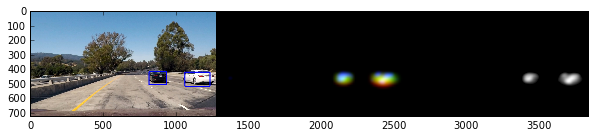

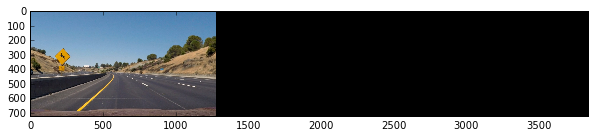

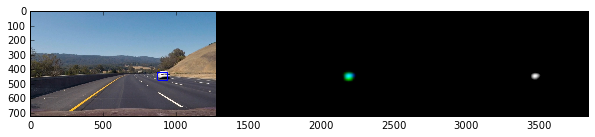

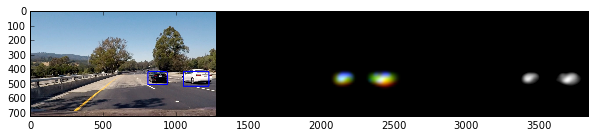

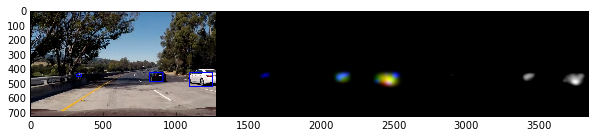

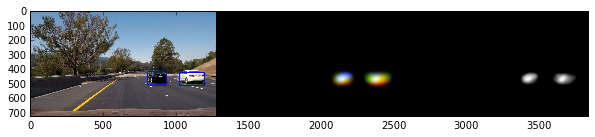

In [16]:
def output_images():
    # Test undistortion on an image
    dir_name = "./test_images"
    file_list = glob.glob(dir_name + "/*.jpg")
    image_list =[]
    pipe = Pipeline()
    for file_name in tqdm(file_list):
        img = cv2.cvtColor(cv2.imread(file_name),cv2.COLOR_BGR2RGB)
        fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
        ax1.imshow(pipe.process(img))
        fig.savefig("./output_images/"+ file_name.split('\\')[-1], bbox_inches='tight')
    return image_list
    
output_images()

In [8]:
from moviepy.editor import VideoFileClip
def test_vid(image, funcs):
    vis = []
    for func in funcs:
        vis.append(func(image))
    result = np.concatenate(vis, axis=1)
    return result
def process_video(input_file):
    output_file = "./output_videos/" + input_file.split('/')[-1]
    clip1 = VideoFileClip(input_file)
    pipe = Pipeline(False)
    output_clip = clip1.fl_image(pipe.process)
    output_clip.write_videofile(output_file, audio=False)

process_video("./test_videos/test_video.mp4")
process_video("./test_videos/project_video.mp4")

[MoviePy] >>>> Building video ./output_videos/test_video.mp4
[MoviePy] Writing video ./output_videos/test_video.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 38/39 [00:25<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video.mp4 

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:05<00:00,  1.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

